In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'calc'))

In [3]:
from amm_math import (
    calc_spot_price, calc_token_balance, calc_out_given_in, calc_in_given_out, 
    set_amm_state, set_amm_state_rebalance, get_amm_spot_prices, get_amm_balance, 
    simple_swap_from_coin, simple_swap_to_coin, simulate_swaps_from_coin,
    calc_balancer_invariant, mint_redeem, perform_action
)

In [4]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
%matplotlib inline

In [6]:
# Weights
w_c, w_l, w_s = sp.symbols('w_c w_l w_s', positive=True)
# Token balances
x_c, x_l, x_s = sp.symbols('x_c x_l x_s', positive=True)
# Prices - in units of locked up collateral
v = sp.symbols('v', positive=True) 
# Swap fee in fraction of input tokens
s_f = sp.symbols('s_f')
# Decimal scaling 
d_c, d_p = sp.symbols('d_c d_p', positive=True)
# Collateral backing L + S 
# e.g. for $100.000_000_000_000_000_000 = 1.000_000 mt
# this is 100*10**18 / 1*10**6 = 10**14
C = sp.symbols('C', positive=True)

In [7]:
help(calc_spot_price)

Help on function calc_spot_price in module amm_math:

calc_spot_price(bI, wI, bO, wO, sF=0)
    calcSpotPrice                                                                             //
     sP = spotPrice                                                                            //
     bI = tokenBalanceIn                ( bI / wI )         1                                  //
     bO = tokenBalanceOut         sP =  -----------  *  ----------                             //
     wI = tokenWeightIn                 ( bO / wO )     ( 1 - sF )                             //
     wO = tokenWeightOut                                                                       //
     sF = swapFee



In [8]:
# e.g. condition for spot price of long token without fees to be v*C
calc_spot_price(x_c, w_c, x_l, w_l) - v*C

-C*v + w_l*x_c/(w_c*x_l)

In [9]:
# Constraint 1: sum of weights is 1
sp.Equality(w_c + w_l + w_s, 1)

Eq(w_c + w_l + w_s, 1)

In [10]:
# Constraint 2: Long token price is v*C, C is underlying collateral of pair
sp.Equality(calc_spot_price(x_c, w_c, x_l, w_l, 0), v*C)

Eq(w_l*x_c/(w_c*x_l), C*v)

In [11]:
# Constraint 3: Short token price is (1-v)*C, C is underlying collateral of pair
sp.Equality(calc_spot_price(x_c, w_c, x_s, w_s, 0), (1-v)*C)

Eq(w_s*x_c/(w_c*x_s), C*(1 - v))

In [12]:
sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, 0) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, 0) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [w_c, w_l, w_s])

In [13]:
sp.Equality(w_c, sol[w_c])

Eq(w_c, x_c/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [14]:
sp.Equality(w_l, sol[w_l])

Eq(w_l, C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [15]:
sp.Equality(w_s, sol[w_s])

Eq(w_s, -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [16]:
# Full set of weights needed to set the spot prices of long and short tokens
sol

{w_c: x_c/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_l: C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_s: -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)}

In [17]:
# Check spot prices
calc_spot_price(x_c, w_c, x_l, w_l, s_f).subs(sol) # Long spot price

C*v/(1 - s_f)

In [18]:
calc_spot_price(x_c, w_c, x_s, w_s, s_f).subs(sol)

-C*(v - 1)/(1 - s_f)

In [19]:
# Input token amounts for swaps
a_c, a_l, a_s = sp.symbols('a_c a_l a_s', positive=True)

In [20]:
n, d = sp.fraction(w_c.subs(sol))

In [21]:
w_c.subs(sol).subs({d: 1})

x_c

# Working with AMM State
We now look at the state of the AMM after performing operations such as swapping from C to L or vice versa.

In [22]:
help(set_amm_state)

Help on function set_amm_state in module amm_math:

set_amm_state(x_c, x_l, x_s, v, C, sF=0)
    For fixed token balances calculate the weights needed to achieve
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S



In [23]:
# Check that we get the correct price 
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        100,     # 100 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

In [24]:
# Note that we don't need to have the same number of tokens to achieve equal L and S price
# as the weights can achieve any price
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        10,      # 10 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

## Trading - simple swaps 
Look at what happens when we trade with the pool without using the Mettalex vault to mint and redeem tokens.  We see arbitrage opportunities being created when L + S != C.

To avoid this arbitrage opportunity we can rebalance the pool after each swap so that L + S = C

In [25]:
help(simple_swap_from_coin)

Help on function simple_swap_from_coin in module amm_math:

simple_swap_from_coin(state, aI, to_long=True, sF=0, coin_per_pair=1, rebalance=False, rebalance_fun=<function set_amm_state at 0x7fde39d967a0>)
    Swap a_c coins in for specified token (1=L, 2=S)



In [26]:
simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)

([10500,
  90.7029478458050,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 9.29705215419502,
 53.7804878048780)

In [27]:
get_amm_spot_prices(simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)[0])

[57.8812500000000, 52.5000000000000]

In [28]:
help(simple_swap_to_coin)

Help on function simple_swap_to_coin in module amm_math:

simple_swap_to_coin(state, aI, from_long=True, sF=0, coin_per_pair=1, rebalance=False, rebalance_fun=<function set_amm_state at 0x7fde39d967a0>)
    Swap position tokens in for coin



In [29]:
simple_swap_to_coin(set_amm_state(10000, 100, 100, 0.5, 100), 1)

([9950.37190209989,
  101,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 49.6280979001085,
 49.6280979001085)

### Price impact for purchasing position tokens 

In [30]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(*[simple_swap_from_coin(initial_state, c) for c in coin_in])

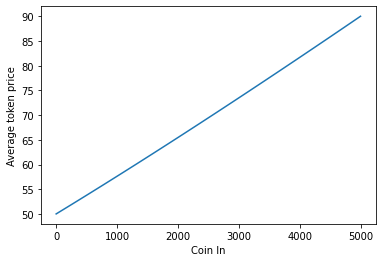

In [31]:
_ = plt.plot(coin_in, avg_price)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Average token price')

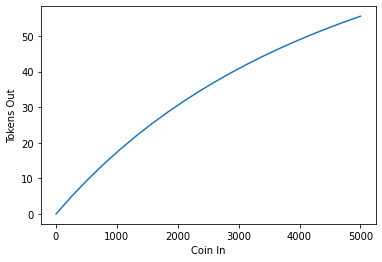

In [32]:
_ = plt.plot(coin_in, tok_out)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Tokens Out')

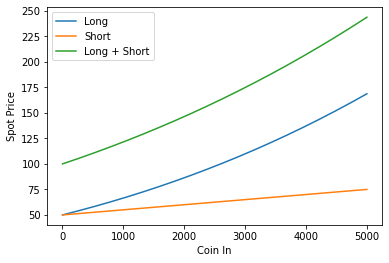

In [33]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

### Price impact for selling position tokens

In [34]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(*[simple_swap_to_coin(initial_state, t) for t in tok_in])

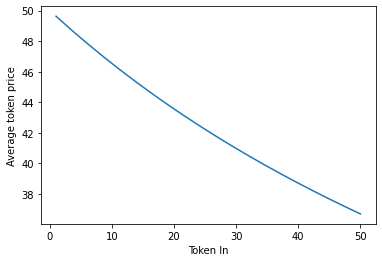

In [35]:
_ = plt.plot(tok_in, avg_price)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Average token price')

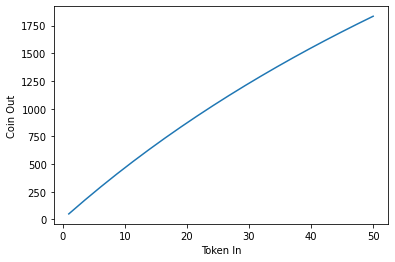

In [36]:
_ = plt.plot(tok_in, coin_out)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Coin Out')

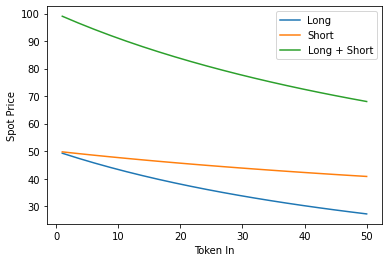

In [37]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

# Pool balance
What is the value of the assets in the pool?  
* A conservative option is to count only coin and paired tokens in which case value is $x_c + \min(x_l, x_s)*C$.  
* A less conservative option uses the spot price of all assets in pool in which case value is $x_c + x_l*v_l*C + x_s*v_s*C$ where the current spot price fractions $v_p, v_s$ reflect the pool spot price taking into account position imbalances i.e. $v_p = \frac{x_c}{x_l}\frac{w_l}{w_c}/C$ etc.

Use the latter value function for the moment and see how we can rebalance the pool after swap to keep the value constant.

In [38]:
help(get_amm_balance)

Help on function get_amm_balance in module amm_math:

get_amm_balance(state)



In [39]:
get_amm_balance(initial_state)

20000.0000000000

In [40]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])
# No rebalancing, raw C->L (or C->S) swap
states_raw, tok_out_raw, avg_price_raw = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=False) for c in coin_in])

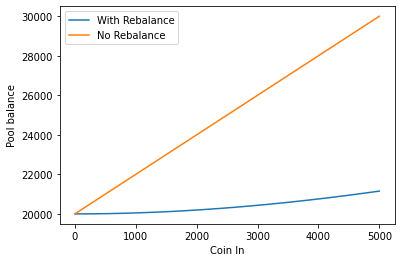

In [41]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
balances_raw = np.array([get_amm_balance(s) for s in states_raw])
_ = plt.plot(coin_in, balances)
_ = plt.plot(coin_in, balances_raw) # No rebalance
_ = plt.legend(['With Rebalance', 'No Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

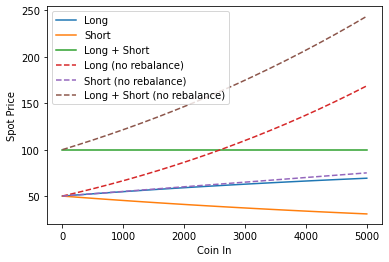

In [42]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
spot_prices_raw = np.array([get_amm_spot_prices(s) for s in states_raw])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.plot(coin_in, spot_prices_raw, linestyle='--')
_ = plt.plot(coin_in, np.sum(spot_prices_raw, axis=1), linestyle='--')
_ = plt.legend(['Long', 'Short', 'Long + Short', 
                'Long (no rebalance)', 'Short (no rebalance)', 'Long + Short (no rebalance)'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

# Swap scenarios
Testing different options to swap coin for position tokens and vice versa, while avoiding arbitrage opportunities and loss of liquidity.  We focus on two key aspects:
* do the spot prices for long and short sum to the value of the undelying collateral?
* does the balance of the autonomous market maker not decrease after a swap? 

In [43]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

In [44]:
get_amm_balance(initial_state)

20000.0000000000

In [45]:
get_amm_spot_prices(initial_state)

[50.0000000000000, 50.0000000000000]

## Original strategy: swap C for L directly

In [46]:
buy_long_no_mint = simple_swap_from_coin(initial_state, 500)[0]

In [47]:
buy_long_no_mint

[10500,
 90.7029478458050,
 100,
 0.500000000000000,
 0.250000000000000,
 0.250000000000000]

In [48]:
get_amm_spot_prices(buy_long_no_mint)

[57.8812500000000, 52.5000000000000]

In [49]:
get_amm_balance(buy_long_no_mint)

21000.0000000000

Problem: both token prices go up

### Modification: rebalance to scale weights such that sum of long and short spot price equal collateral
(this was actually the last thing we tried, after the minting during swap option)

In [50]:
buy_long_no_mint_rebalance = simple_swap_from_coin(initial_state, 500, coin_per_pair=100, rebalance=True)[0]

In [51]:
buy_long_no_mint_rebalance

[10500,
 90.7029478458050,
 100,
 0.524672469623600,
 0.237663765188200,
 0.237663765188200]

In [52]:
get_amm_spot_prices(buy_long_no_mint_rebalance)

[52.4375743162901, 47.5624256837099]

In [53]:
get_amm_balance(buy_long_no_mint_rebalance)

20012.4851367420

In [54]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[simple_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])

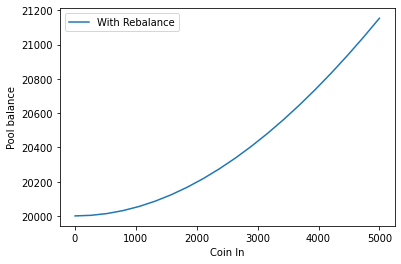

In [55]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
_ = plt.plot(coin_in, balances)
_ = plt.legend(['With Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

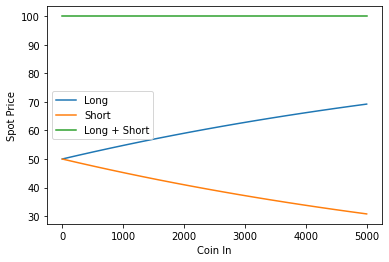

In [56]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

This looks good!  Sum of prices = 100, and balance has increased slightly (even without fees)

## Check swapping position token for coin

In [57]:
sell_long_no_mint_rebalance = simple_swap_to_coin(
    buy_long_no_mint_rebalance, 100-buy_long_no_mint_rebalance[1], coin_per_pair=100, rebalance=True)[0]

In [58]:
get_amm_spot_prices(sell_long_no_mint_rebalance)

[49.9999999999998, 49.9999999999998]

In [59]:
get_amm_balance(sell_long_no_mint_rebalance)

20045.9921189573

So round trip of buy L from AMM, sell L back to AMM results in the AMM gaining money.  See below for a more systematic investigation.

In [60]:
help(simulate_swaps_from_coin)

Help on function simulate_swaps_from_coin in module amm_math:

simulate_swaps_from_coin(x_c_0, x_l_0, x_s_0, v, C, from_coin=True, c_max=1000, n_row=1, offset=0, f=None)



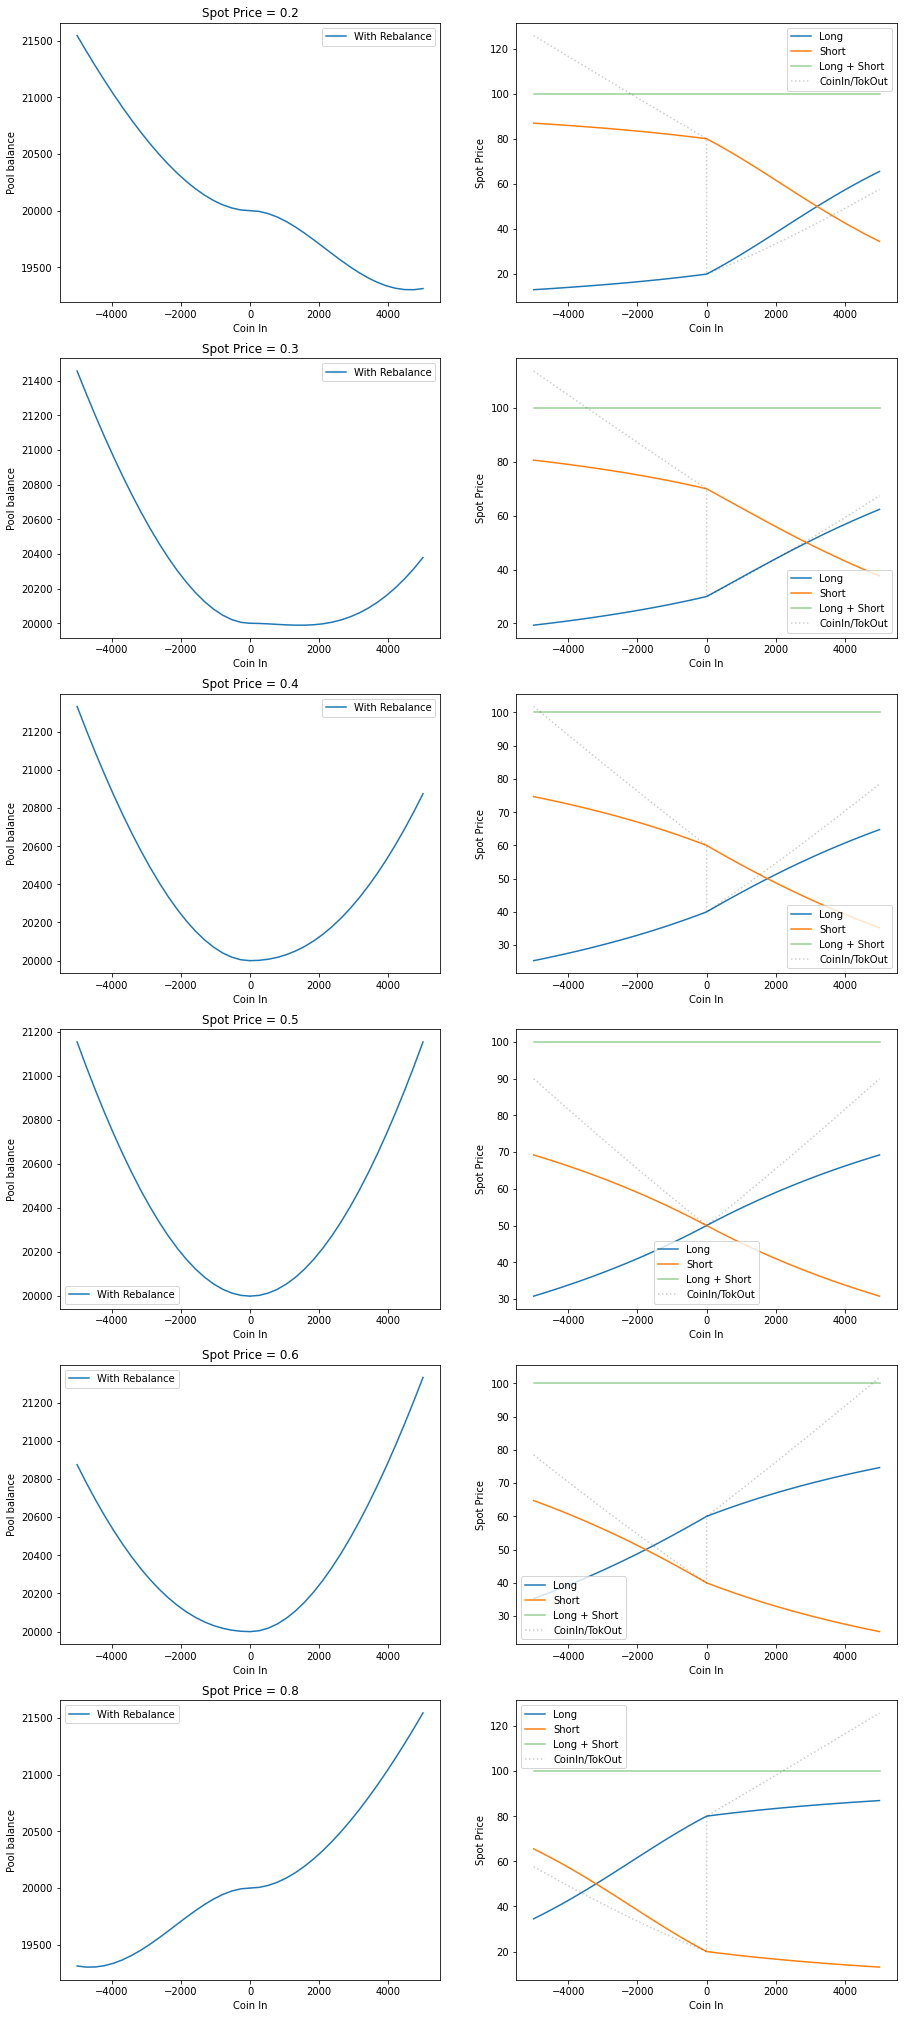

In [61]:
asset_spots = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
n_spots = len(asset_spots)
f = plt.figure(figsize=(15, 6*n_spots))
for i, spot in enumerate(asset_spots):
    simulate_swaps_from_coin(10000, 100, 100, spot, 100, c_max=5000, n_row=n_spots, offset=i)
f.savefig('amm_spot_prices.png')

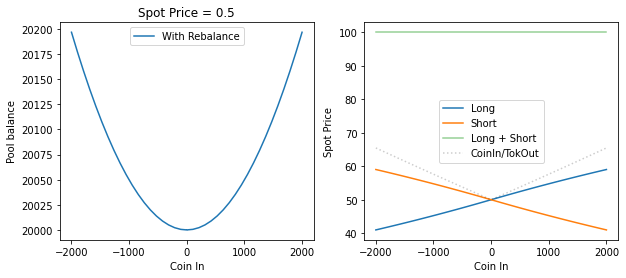

In [62]:
asset_spots = [ 0.5]
n_spots = len(asset_spots)
f = plt.figure(figsize=(10, 4*n_spots))
for i, spot in enumerate(asset_spots):
    simulate_swaps_from_coin(10000, 100, 100, spot, 100, c_max=2000, n_row=n_spots, offset=i, f=f)
f.savefig('amm_spot_prices_50.png')

In [63]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(
    *[simple_swap_to_coin(initial_state, t, coin_per_pair=100, rebalance=True) 
      for t in tok_in])

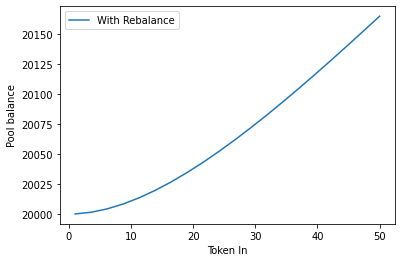

In [64]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
_ = plt.plot(tok_in, balances)
_ = plt.legend(['With Rebalance'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Pool balance')

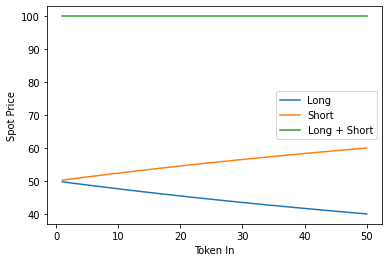

In [65]:
spot_prices = np.array([get_amm_spot_prices(s) for s in states])

_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

In [66]:
calc_balancer_invariant(*initial_state)

1000.00000000000

# State Space Curves for Different Operations
We can think of the AMM operations as movements in the six-dimensional phase space defined by token balances and weights:
* mint or redeem moves the state along the line preserving total coin balance i.e. coin plus paired position tokens
* swap moves the state along the Balancer invariant

The smart pool adjusts the Balancer weights and proportions of different tokens (the latter via mint/redeem operations) after swaps, liquidity supply, and price updates in order to reduce arbitrage opportunities.

Below we plot how the state moves and curves change in response to these operations.

In [72]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

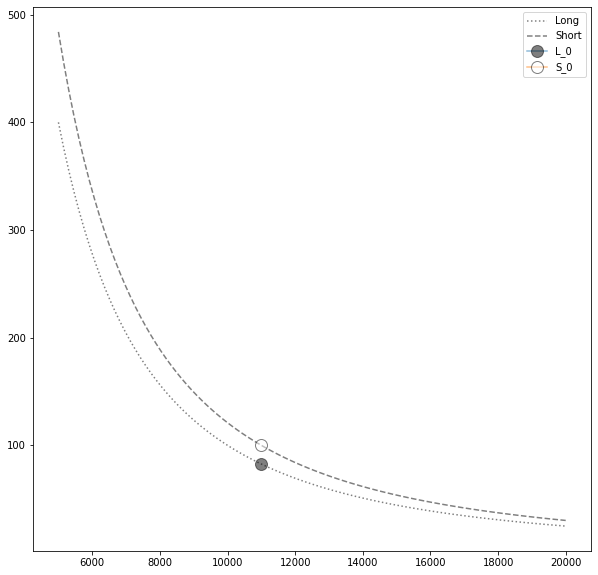

In [73]:
x = np.linspace(5000., 20000., 100).reshape(-1, 1)
n_c_0, n_l_0, n_s_0, w_c_0, w_l_0, w_s_0 = simple_swap_from_coin(initial_state, 1000)[0]
k_0 = calc_balancer_invariant(*initial_state)
f = plt.figure(figsize=(10,10))
_ = plt.plot(x, calc_token_balance(x, n_s_0, w_c_0, w_s_0, k_0),
            c='k', linestyle=':', alpha=0.5)
_ = plt.plot(x, calc_token_balance(x, n_l_0, w_c_0, w_l_0, k_0),
            c='k', linestyle='--', alpha=0.5)
_ = plt.plot(n_c_0, n_l_0, markerfacecolor='k', marker='o', markeredgecolor='k', markersize=12, alpha=0.5)
_ = plt.plot(n_c_0, n_s_0, markerfacecolor='w', marker='o', markeredgecolor='k', markersize=12, alpha=0.5)
_ = plt.legend(['Long', 'Short', 'L_0', 'S_0'])

In [122]:
def plot_action(s_0, a_c, n_c_min=5000., n_c_max=20000., action='swap_from_coin', coin_per_pair=100, **swap_params):
    n_c_0, n_l_0, n_s_0, w_c_0, w_l_0, w_s_0 = s_0
    spot_l_0, spot_s_0 = get_amm_spot_prices(s_0)
    
    s_1, tok_out, avg_price = perform_action(action, s_0, a_c, coin_per_pair=coin_per_pair, **swap_params)
            
    n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = s_1
    spot_l_1, spot_s_1 = get_amm_spot_prices(s_1)
    
    x = np.linspace(n_c_min, n_c_max, 100).reshape(-1, 1)
    
    # Plot initial state 
    k_0 = calc_balancer_invariant(*s_0)
    _ = plt.plot(x, calc_token_balance(x, n_s_0, w_c_0, w_s_0, k_0),
                c='k', linestyle=':', alpha=0.2, label='Initial Invariant')
    _ = plt.plot(x, calc_token_balance(x, n_l_0, w_c_0, w_l_0, k_0),
                c='k', linestyle=':', alpha=0.2)
    _ = plt.plot(n_c_0, n_l_0, markerfacecolor='k', marker='o', markeredgecolor='k', markersize=8, alpha=0.2)
    _ = plt.plot(n_c_0, n_s_0, markerfacecolor='w', marker='o', markeredgecolor='k', markersize=8, alpha=0.2)

    # Plot state movement
    if action != 'mint_redeem':
        x_move = np.linspace(float(min(n_c_0, n_c_1)), float(max(n_c_0, n_c_1)), 100).reshape(-1, 1)
        if n_l_1 != n_l_0:
            # Long swap
            _ = plt.plot(x_move, calc_token_balance(x_move, n_s_0, w_c_0, w_s_0, k_0),
                        c='k', linestyle='-', alpha=0.5, label='Swap')
            _ = plt.plot([n_c_0, n_c_1], [n_s_0, n_s_1], c='k', alpha=0.5)
        else:
            # Short swap
            _ = plt.plot(x_move, calc_token_balance(x_move, n_l_0, w_c_0, w_l_0, k_0),
                        c='k', linestyle='-', alpha=0.5, label='Swap')
            _ = plt.plot([n_c_0, n_c_1], [n_l_0, n_l_1], c='k', alpha=0.5)
    else:
        _ = plt.plot([n_c_0, n_c_1], [[n_l_0, n_s_0], [n_l_1, n_s_1]], 
                     c='k', alpha=0.5, label='Mint/Redeem')
            
    
    # Plot invariant curves without rebalance of weights for final state
    _ = plt.plot(x, calc_token_balance(x, n_s_1, w_c_0, w_s_0, k_0),
                c='k', linestyle='--', alpha=0.2, label='Intermediate Invariant')
    _ = plt.plot(x, calc_token_balance(x, n_l_1, w_c_0, w_l_0, k_0),
                c='k', linestyle='--', alpha=0.2)
    
    
    # Plot final invariant after rebalance
    k_1 = calc_balancer_invariant(*s_1)
    _ = plt.plot(x, calc_token_balance(x, n_s_1, w_c_1, w_s_1, k_1),
                c='k', linestyle='-', alpha=0.2, label='Final Invariant')
    _ = plt.plot(x, calc_token_balance(x, n_l_1, w_c_1, w_l_1, k_1),
                c='k', linestyle='-', alpha=0.2)
    
    # Plot final state 
    ax_l = plt.plot(n_c_1, n_l_1, markerfacecolor='k', marker='o', 
                    markeredgecolor='k', markersize=12, alpha=0.5, label='Long', linestyle='none')
    ax_s = plt.plot(n_c_1, n_s_1, markerfacecolor='w', marker='o', 
                    markeredgecolor='k', markersize=12, alpha=0.5, label='Short', linestyle='none')
    
    
    _ = plt.title(
        f'Tokens in: {a_c:0.2f}  Tokens out: {tok_out:0.2f}  Average Price: {avg_price:0.2f}\n'
        + f'Old balance: {n_c_0:0.2f} Coin  {n_l_0:0.2f} Long  {n_s_0:0.2f}  Short\n'
        + f'New balance: {n_c_1:0.2f} Coin  {n_l_1:0.2f} Long  {n_s_1:0.2f}  Short\n'
        + f'Old spot prices: Long {spot_l_0:0.2f}  Short {spot_s_0:0.2f}\n'
        + f'New spot prices: Long {spot_l_1:0.2f}  Short {spot_s_1:0.2f}\n'
    )
    _ = plt.xlabel('$n_c$')
    _ = plt.ylabel('$n_l, n_s$')
    _ = plt.legend()
    
    return s_1, tok_out, avg_price

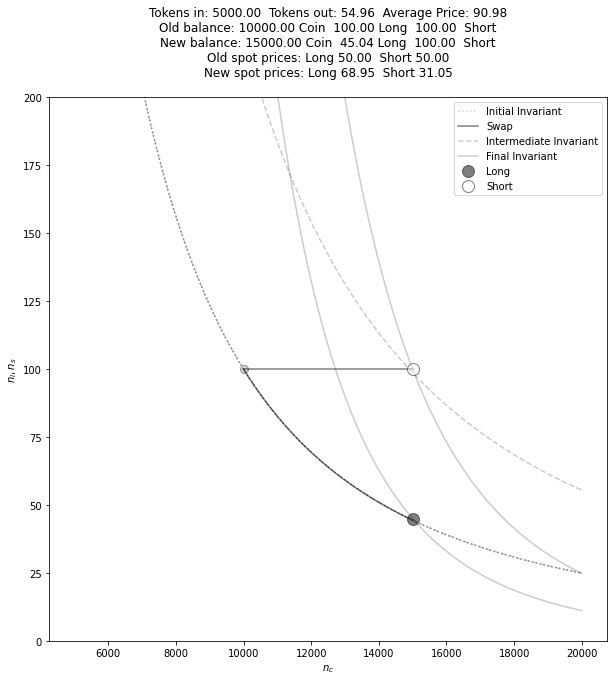

In [75]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0, 200))

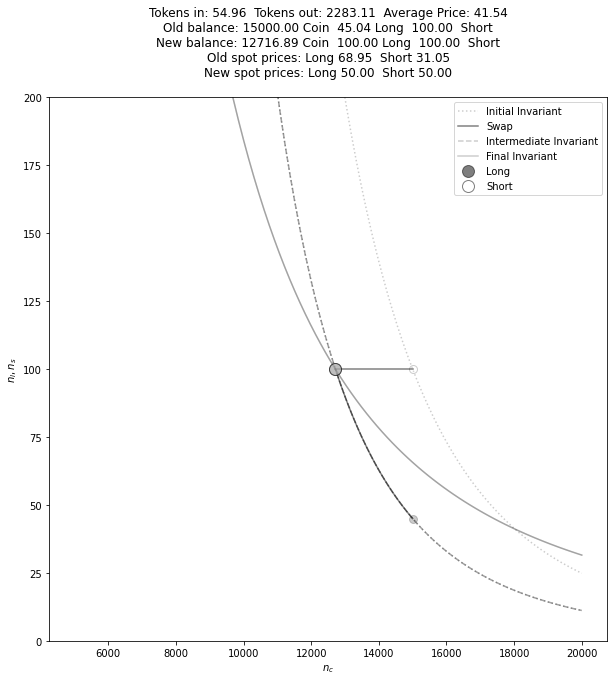

In [76]:
f = plt.figure(figsize=(10,10))
swap2_state = plot_action(swap1_state[0], swap1_state[1], action='swap_to_coin', rebalance=True, coin_per_pair=100, sF=0.0)
_ = plt.ylim((0, 200))

In [77]:
swap2_state

([12716.8850470710,
  100.000000000000,
  100,
  0.559798802552406,
  0.220100598723797,
  0.220100598723797],
 2283.11495292898,
 41.5436727071357)

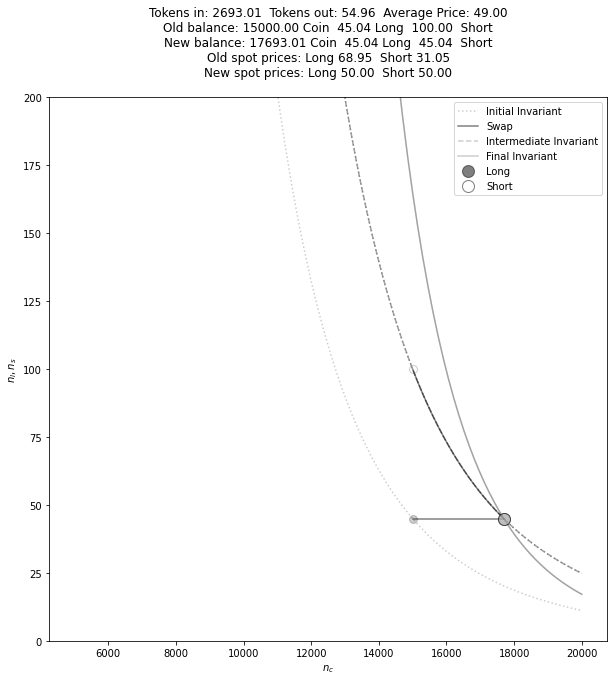

In [78]:
# Buy short equal to long bought in first swap
n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = swap1_state[0]
a_c_2 = calc_in_given_out(n_s_1, w_s_1, n_c_1, w_c_1, swap1_state[1])

f = plt.figure(figsize=(10,10))
swap2a_state = plot_action(swap1_state[0], a_c_2, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0, to_long=False)
_ = plt.ylim((0, 200))

In [79]:
swap2a_state

([17693.0120204100,
  45.0430160803567,
  45.0430160803567,
  0.797078976157572,
  0.101460511921214,
  0.101460511921214],
 54.9569839196433,
 49.0021800386222)

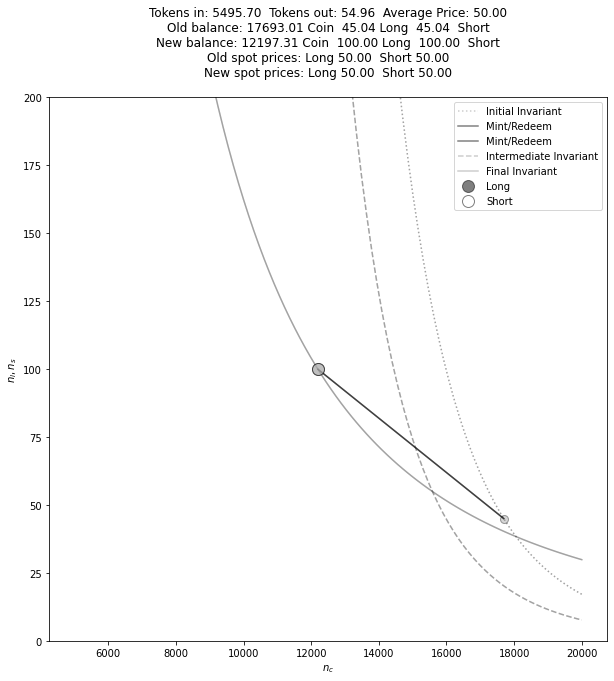

In [80]:
f = plt.figure(figsize=(10,10))
swap2b_state = plot_action(
    swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, 
    action='mint_redeem', rebalance=True, coin_per_pair=100
)
_ = plt.ylim((0, 200))

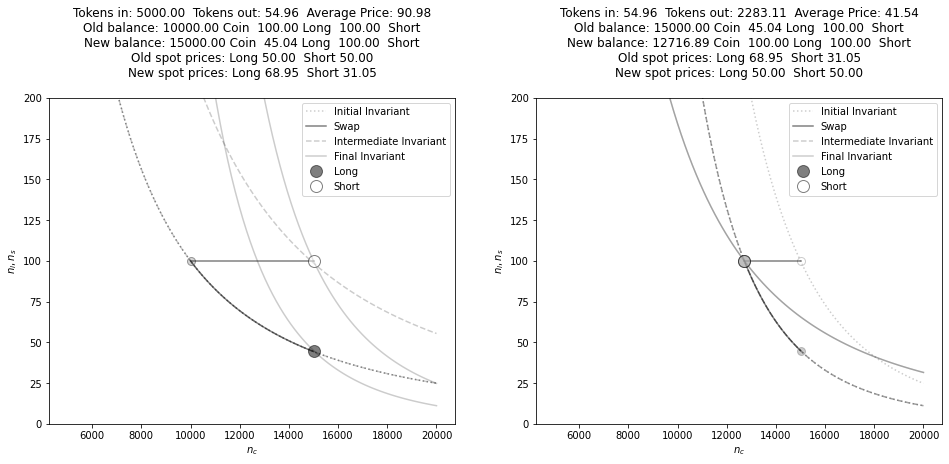

In [81]:
f = plt.figure(figsize=(16, 6))
_ = plt.subplot(1,2,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

_ = plt.subplot(1,2,2)
swap2_state = plot_action(swap1_state[0], swap1_state[1], action='swap_to_coin', rebalance=True, coin_per_pair=100, sF=0.0)
_ = plt.ylim((0,200))
f.savefig('buy_long_sell_long.png', bbox_inches='tight')

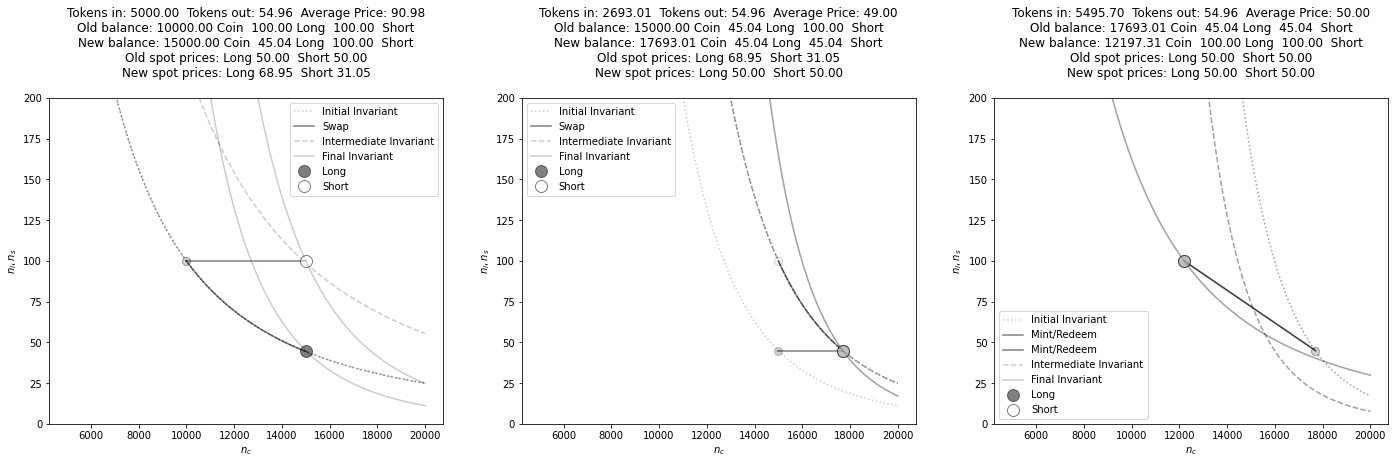

In [82]:
f = plt.figure(figsize=(24, 6))
_ = plt.subplot(1,3,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = swap1_state[0]
a_c_2 = calc_in_given_out(n_s_1, w_s_1, n_c_1, w_c_1, swap1_state[1])
_ = plt.subplot(1,3,2)
swap2a_state = plot_action(swap1_state[0], a_c_2, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0, to_long=False)
_ = plt.ylim((0,200))

_ = plt.subplot(1,3,3)
swap2b_state = plot_action(
    swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, 
    action='mint_redeem', rebalance=True, coin_per_pair=100
)
_ = plt.ylim((0,200))
f.savefig('buy_long_buy_short_mint.png', bbox_inches='tight')

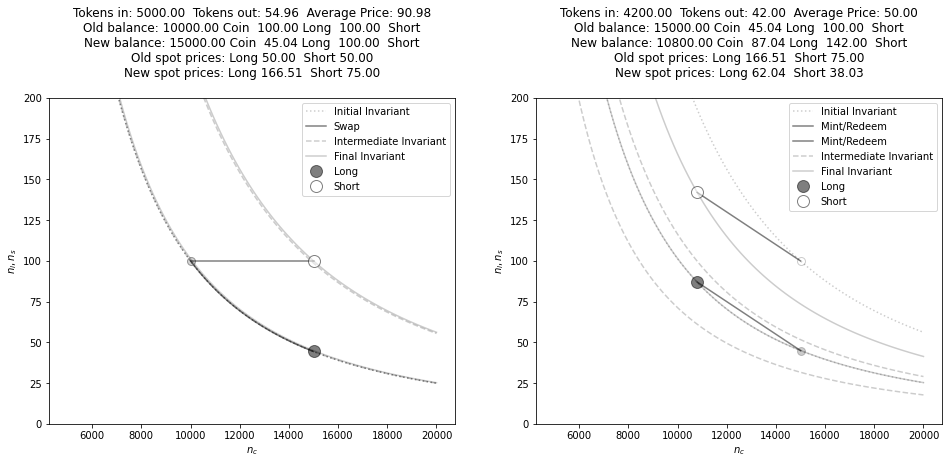

In [83]:
# Try fixing price sum with minting to change balances rather than reweighting
f = plt.figure(figsize=(16, 6))
_ = plt.subplot(1,2,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=False, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

_ = plt.subplot(1,2,2)
swap2_state = plot_action(swap1_state[0], 4200, action='mint_redeem', rebalance=False, coin_per_pair=100, sF=0.0)
_ = plt.ylim((0,200))
f.savefig('buy_long_mint.png', bbox_inches='tight')


In [172]:
perform_action('swap_from_coin', initial_state, 1000, rebalance=True)

([11000,
  82.6446280991735,
  100,
  0.548634619724667,
  0.225682690137667,
  0.225682690137666],
 17.3553719008265,
 57.6190476190476)

In [229]:
def plot_orderbook(state, is_long=True, **plot_args):
    tok_ind = 1 if is_long else 2

    sell_volume = np.flip(np.linspace(float(state[tok_ind]/1000.), float(state[tok_ind]/2.), 20))
    sell_price = np.array(
        [perform_action('swap_to_coin', state, v, rebalance=False, from_long=is_long)[2] 
         for v in sell_volume]
    )
    
    buy_volume = np.linspace(float(state[0]/1000.), float(state[0]/2.), 20)
    buy_price = np.array(
        [perform_action('swap_from_coin', state, v, rebalance=False, to_long=is_long)[2] 
         for v in buy_volume]
    )

    _ = plt.plot(
        np.concatenate([sell_price, buy_price]), 
        np.concatenate([sell_volume, buy_volume / buy_price]), 
        **plot_args)
#     _ = plt.plot(buy_price, buy_volume / buy_price, **plot_args)  # Volume in position tokens

In [230]:
swap1_state = perform_action('swap_from_coin', initial_state, 5000, rebalance=True)

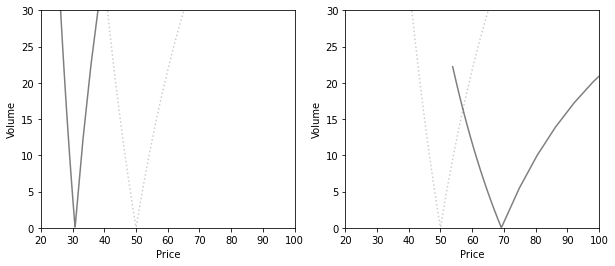

In [231]:
f = plt.figure(figsize=(10,4))
_ = plt.subplot(1,2,1)
plot_orderbook(initial_state, is_long=False, c='k', linestyle=':', alpha=0.2)
plot_orderbook(swap1_state[0], is_long=False, c='k', linestyle='-', alpha=0.5)
_ = plt.xlabel('Price')
_ = plt.ylabel('Volume')
_ = plt.xlim((20,100))
_ = plt.ylim((0, 30))

_ = plt.subplot(1,2,2)
plot_orderbook(initial_state, is_long=True, c='k', linestyle=':', alpha=0.2)
plot_orderbook(swap1_state[0], is_long=True, c='k', linestyle='-', alpha=0.5)
_ = plt.xlabel('Price')
_ = plt.ylabel('Volume')
_ = plt.xlim((20,100))
_ = plt.ylim((0, 30))

In [264]:
def plot_action_orderbook(
    s_0, a_c, n_c_min=5000, n_c_max=20000, action='swap_from_coin', coin_per_pair=100, 
    xlim=None, ylim=None, **swap_params):
    n_c_0, n_l_0, n_s_0, w_c_0, w_l_0, w_s_0 = s_0
    spot_l_0, spot_s_0 = get_amm_spot_prices(s_0)
    
    s_1, tok_out, avg_price = perform_action(action, s_0, a_c, coin_per_pair=coin_per_pair, **swap_params)
            
    n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = s_1
    spot_l_1, spot_s_1 = get_amm_spot_prices(s_1)
    
    # Plot initial state 
    _ = plt.subplot(1,2,1)
    plot_orderbook(s_0, is_long=False, c='k', linestyle=':', alpha=0.2)
    plot_orderbook(s_1, is_long=False, c='k', linestyle='-', alpha=0.5)
    _ = plt.xlabel('Price')
    _ = plt.ylabel('Volume')
    _ = plt.title('Short')
    _ = plt.legend(['Initial', 'Final'])
    if xlim is not None:
        _ = plt.xlim(xlim)
    if ylim is not None:
        _ = plt.ylim(ylim)
    
    
    _ = plt.subplot(1,2,2)
    plot_orderbook(s_0, is_long=True, c='k', linestyle=':', alpha=0.2)
    plot_orderbook(s_1, is_long=True, c='k', linestyle='-', alpha=0.5)
    _ = plt.xlabel('Price')
    _ = plt.ylabel('Volume')
    _ = plt.title('Long')
    _ = plt.legend(['Initial', 'Final'])
    if xlim is not None:
        _ = plt.xlim(xlim)
    if ylim is not None:
        _ = plt.ylim(ylim)
    
    
#     _ = plt.title(
#         f'Tokens in: {a_c:0.2f}  Tokens out: {tok_out:0.2f}  Average Price: {avg_price:0.2f}\n'
#         + f'Old balance: {n_c_0:0.2f} Coin  {n_l_0:0.2f} Long  {n_s_0:0.2f}  Short\n'
#         + f'New balance: {n_c_1:0.2f} Coin  {n_l_1:0.2f} Long  {n_s_1:0.2f}  Short\n'
#         + f'Old spot prices: Long {spot_l_0:0.2f}  Short {spot_s_0:0.2f}\n'
#         + f'New spot prices: Long {spot_l_1:0.2f}  Short {spot_s_1:0.2f}\n'
#     )
#     _ = plt.xlabel('$n_c$')
#     _ = plt.ylabel('$n_l, n_s$')
#     _ = plt.legend()
    
    return s_1, tok_out, avg_price

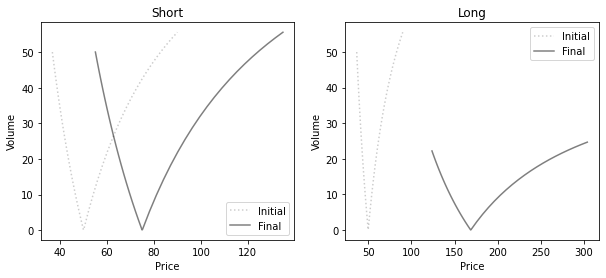

In [265]:
f = plt.figure(figsize=(10,4))
_ = plot_action_orderbook(initial_state, 5000, action='swap_from_coin', rebalance=False)

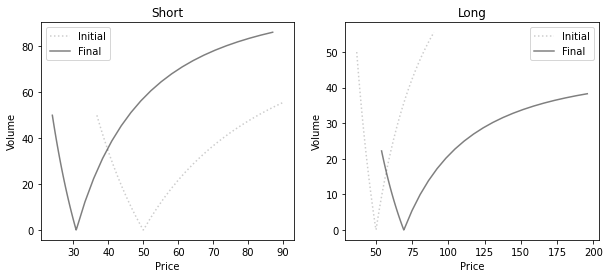

In [266]:
f = plt.figure(figsize=(10,4))
_ = plot_action_orderbook(initial_state, 5000, action='swap_from_coin', rebalance=True)

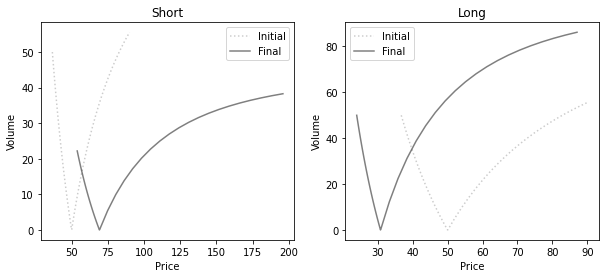

In [267]:
f = plt.figure(figsize=(10,4))
_ = plot_action_orderbook(initial_state, 5000, action='swap_from_coin', rebalance=True, to_long=False)

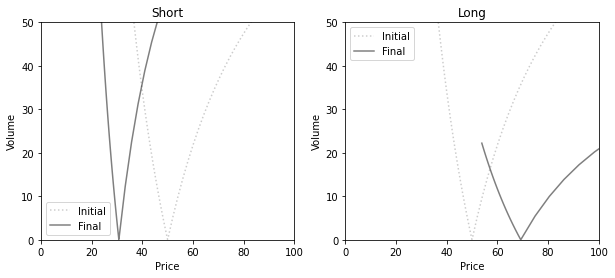

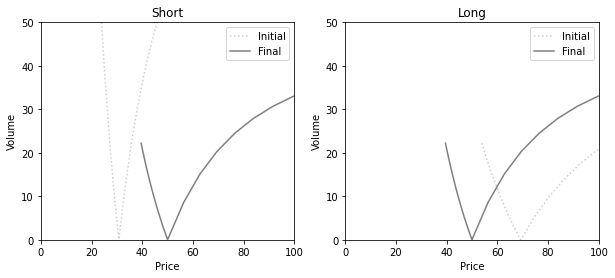

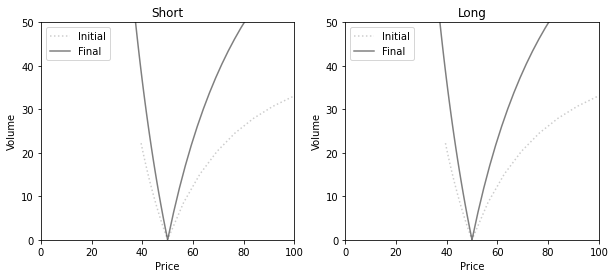

In [270]:
f = plt.figure(figsize=(10, 4))
# _ = plt.subplot(1,3,1)
swap1_state = plot_action_orderbook(
    initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0,
    xlim=(0,100), ylim=(0,50)
)

n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = swap1_state[0]
a_c_2 = calc_in_given_out(n_s_1, w_s_1, n_c_1, w_c_1, swap1_state[1])
# _ = plt.subplot(1,3,2)
f = plt.figure(figsize=(10, 4))

swap2a_state = plot_action_orderbook(
    swap1_state[0], a_c_2, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0, 
    xlim=(0,100), ylim=(0,50), to_long=False)

# _ = plt.subplot(1,3,3)
f = plt.figure(figsize=(10, 4))

swap2b_state = plot_action_orderbook(
    swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, 
    action='mint_redeem', rebalance=True, coin_per_pair=100,
    xlim=(0,100), ylim=(0,50)
)
# f.savefig('buy_long_buy_short_mint.png', bbox_inches='tight')